In [71]:
from orphics import io, maps, lensing, cosmology, stats
from pixell import enmap, curvedsky
import numpy as np
import os, sys
import healpy as hp
import matplotlib.pylab as plt
import symlens as s
from symlens import utils
import importlib
from mpi4py import MPI
import pandas as pd
import tools

In [72]:
# Simulate bias of lensing reconstruction from non-Gaussian kSZ

# map source, 'Colin' or 'websky'
map_source = 'websky'
# 'lt' for late-time kSZ or 'ri' for reionization kSZ
ksz_type = 'ri'

# experiment configuration, name:[nlev_t,beam_arcmin]
# experiments = {'reference':[0,0]}
experiments = {'Planck_SMICA':[45,5], 'CMB_S3':[7,1.4], 'CMB_S4':[1, 3]}

# Use maps provided by websky
map_path = 'maps/' + map_source + '/'
# Path of output data
data_path = 'data/'

# lmin, lmax for cmb maps
ellmin = 30
# ellmaxs = [4000]
ellmaxs = [3000, 4000, 4500]
# bin width for reconstructed kappa powerspectrum
delta_L = 200

# pixel size in arcmin
px_arcmin = 1.
# size of cutout square
width_deg = 30

print('bin_width=%s' %(delta_L))
# Let's define a cut-sky cylindrical geometry with 1 arcminute pixel width
# and a maximum declination extent of +- 45 deg (see below for reason)
# band width in deg
decmax = 15
# shape and wcs  of the band
band_shape, band_wcs = enmap.band_geometry(dec_cut=np.deg2rad(decmax),
                                           res=np.deg2rad(px_arcmin / 60.))

band_modlmap = enmap.modlmap(band_shape, band_wcs)

# Read in cmb_alm
print('reading in CMB map')
cmb_alm = hp.read_alm(map_path + 'lensed_cmb_alm.fits', hdu=1)
# Get cmb band map
cmb_band = curvedsky.alm2map(cmb_alm, enmap.empty(band_shape, band_wcs))


# Read in ksz_alm and get ksz band map
print('reading in %s %s kSZ map' %(map_source, ksz_type))
ksz_alm = hp.read_alm(map_path + f'ksz_{ksz_type}_alm.fits')
ksz_band = curvedsky.alm2map(ksz_alm, enmap.empty(band_shape, band_wcs))


# Read in ksz_g_alm  and get ksz_g_band map, 'g' is for gaussian
print('reading in ksz_g map')
ksz_g_alm = hp.read_alm(map_path + f'ksz_{ksz_type}_g_alm_6000.fits')
ksz_g_band = curvedsky.alm2map(ksz_g_alm, enmap.empty(band_shape, band_wcs))

# Read in input kappa map for cross correlation check
print('reading in kappa map')
kap_alm = hp.read_alm(map_path + 'kappa_alm.fits')
kap_band = curvedsky.alm2map(kap_alm, enmap.empty(band_shape, band_wcs))

bin_width=200
reading in CMB map
reading in websky ri kSZ map
reading in ksz_g map
reading in kappa map


In [73]:
nlev_t = 1
beam_arcmin = 3
ellmax = 4000
ells = np.arange(0, ellmax, 1)
Cl_noise_TT = (nlev_t * np.pi / 180. / 60.)**2 * np.ones(ells.shape)
# deconvolved noise power spectrum
Cl_noise_TT = Cl_noise_TT / utils.gauss_beam(ells, beam_arcmin)**2
# deconvolved noise band map
noise_band = curvedsky.rand_map(band_shape, band_wcs, Cl_noise_TT)

In [74]:
shape = cmb_band.shape

In [75]:
# npix x npix cutouts
npix = int(width_deg * 60 / px_arcmin)
# total number of tiles
ntiles = int(np.prod(shape) / npix**2)
# self.ntiles = 1
# number of tiles in a row
num_x = int(360 / width_deg)

In [112]:
ex, ey = 0, 0
cmb_tg = (cmb_band + ksz_g_band + noise_band)[0:npix, 0:npix]
cmb_tg = (cmb_band  + noise_band)[0:npix, 0:npix]
cmb_t = (cmb_band + ksz_band + noise_band)[0:npix, 0:npix]

In [113]:
map_shape = cmb_tg.shape
map_wcs = cmb_tg.wcs
map_modlmap = enmap.modlmap(map_shape, map_wcs)

In [114]:
map_modlmap.max()
ells = np.arange(0, map_modlmap.max() + 1, 1)
ells

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.5360e+04, 1.5361e+04,
       1.5362e+04])

In [115]:
import new_tools
importlib.reload(new_tools)
Lmin = 40
Lmax = ellmax
results= new_tools.kappa(ellmin, ellmax, Lmin, Lmax, delta_L, nlev_t, beam_arcmin, enmap1=cmb_tg, enmap2=cmb_tg)

In [116]:
inkappa_cl = hp.alm2cl(kap_alm)
inkappa = kap_band[0:npix, 0:npix]

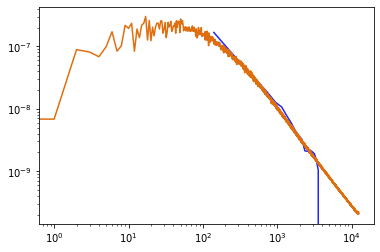

In [117]:
Ls = results['Ls']
kappa = results['kappa']
kappa_cl = results['kappa_cl']
d_cl = results['d_cl']
phi_cl = results['phi_cl']
noise_cl = results['noise_cl']
norm = results['norm']
plt.loglog(Ls, kappa_cl-noise_cl)
plt.loglog( inkappa_cl)
#plt.loglog(Ls, d_cl)
#plt.loglog(Ls, phi_cl)
#plt.loglog(Ls, noise_cl)
#plt.loglog(Ls, norm*Ls**2/4)

In [118]:
taper, w2 = maps.get_taper_deg(map_shape, map_wcs)
inkappa = taper * inkappa
Ls, cross = new_tools.powspec(kappa, inkappa, taper, 3, map_modlmap, Lmin, Lmax, delta_L)
Ls, inkap_cl = new_tools.powspec(inkappa, inkappa, taper, 2, map_modlmap, Lmin, Lmax, delta_L)

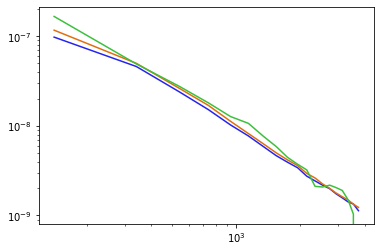

In [120]:
plt.loglog(Ls, cross)
plt.loglog(Ls, inkap_cl)
plt.loglog(Ls, kappa_cl - noise_cl)

In [87]:
# Simulate bias of lensing reconstruction from non-Gaussian kSZ

# map source, 'Colin' or 'websky'
map_source = 'Colin'
# 'lt' for late-time kSZ or 'ri' for reionization kSZ
ksz_type = 'lt'

# experiment configuration, name:[nlev_t,beam_arcmin]
# experiments={'reference':[0,0]}
experiments={'CMB_S4':[1,3]}
#experiments = {'Planck_SMICA':[45,5], 'CMB_S3':[7,1.4], 'CMB_S4':[1,3]}

# Use maps provided by websky
map_path = 'maps/' + map_source + '/'
# Path of output data
data_path = 'data/'

# lmin, lmax for cmb maps
ellmin = 100
ellmaxs = [4000]
# ellmaxs = [3000, 4000, 4500]
# bin width for reconstructed kappa powerspectrum
delta_L = 40

# pixel size in arcmin
px_arcmin = 1.

data_path = 'data/test/'
importlib.reload(tools)
ps = pd.read_csv('data/test/'+map_source+'_'+ksz_type+'_'+'CMB_S4_%s_4000.csv' %(ellmin))
experiment_names = [ name for name in experiments.keys()]
experiment_names[0]

'CMB_S4'

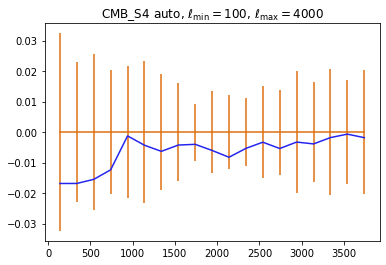

In [88]:
plt.plot(ps['Ls'], ps['bias'])
#plt.errorbar(ps['Ls'], ps['bias'], yerr=ps['bias_err'])
plt.errorbar(ps['Ls'], np.zeros(np.shape(ps['Ls'])), yerr=ps['bias_err'])
plt.title(r'%s auto, ${\ell}_{\mathrm{min}}=%s$, ${\ell}_{\mathrm{max}}=%s$' %(experiment_names[0],ellmin, ellmaxs[0]))
plt.savefig('data/test/'+map_source+'_'+ksz_type+'_'+experiment_names[0]+'_'+'%s_%s.png' %(ellmin, ellmaxs[0]))